## Project Preparation

**Background**

33 million tons of waste has produced in 2024 but 13 million tons of it remains unmanaged. So, why is it so hard to manage? One of many reasons is we still have low public awareness of waste sorting. A survey by GoodStats in November 2024 with 1000 respondents in Indonesia found that 20,5% of respondents are never sort their waste and 55% of them feel that sorting waste is too much trouble. Unsorted waste slows down waste management process and makes it inefficient because most of it still relies on human labor, with the large amount of unsorted waste increasing their workload. We need smarter, automated solutions to support better waste sorting and reduce the burden on human labor.

**Problems Statement**

Based on the background explained above, the problems to be solved in this project are:

- How can we support a society with low awareness of waste sorting to reduce the burden on manual labor and improve waste management efficiency?

- How can we make waste sorting effortless for users and efficient for the system?

**Goals**

So here are the goals that have been set to be achieve in this project : 

- Developing a machine learning model to detect and classify waste types from visual images.

- Analyzing the potential use of deep learning models as part of supporting smart waste management in the future based on model performance.

## Data Preprocessing

In [ ]:
# Import all required libraries
import os
import yaml
from collections import Counter
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
from PIL import Image

**Exploratory Data Analysis**

 Dataset: dataset
Class                     Train      Val        Test       Total     
-----------------------------------------------------------------
Plastic bag - wrapper     2228       854        59         3141      
Cigarette                 2214       565        55         2834      
Unlabeled litter          1419       569        38         2026      
Bottle cap                1318       459        26         1803      
Bottle                    821        320        13         1154      
Other plastic             751        265        28         1044      
Can                       714        267        19         1000      
Carton                    662        263        30         955       
Cup                       583        186        19         788       
Paper                     369        178        10         557       
Broken glass              376        123        51         550       
Other litter              356        178        7          541       
Straw 

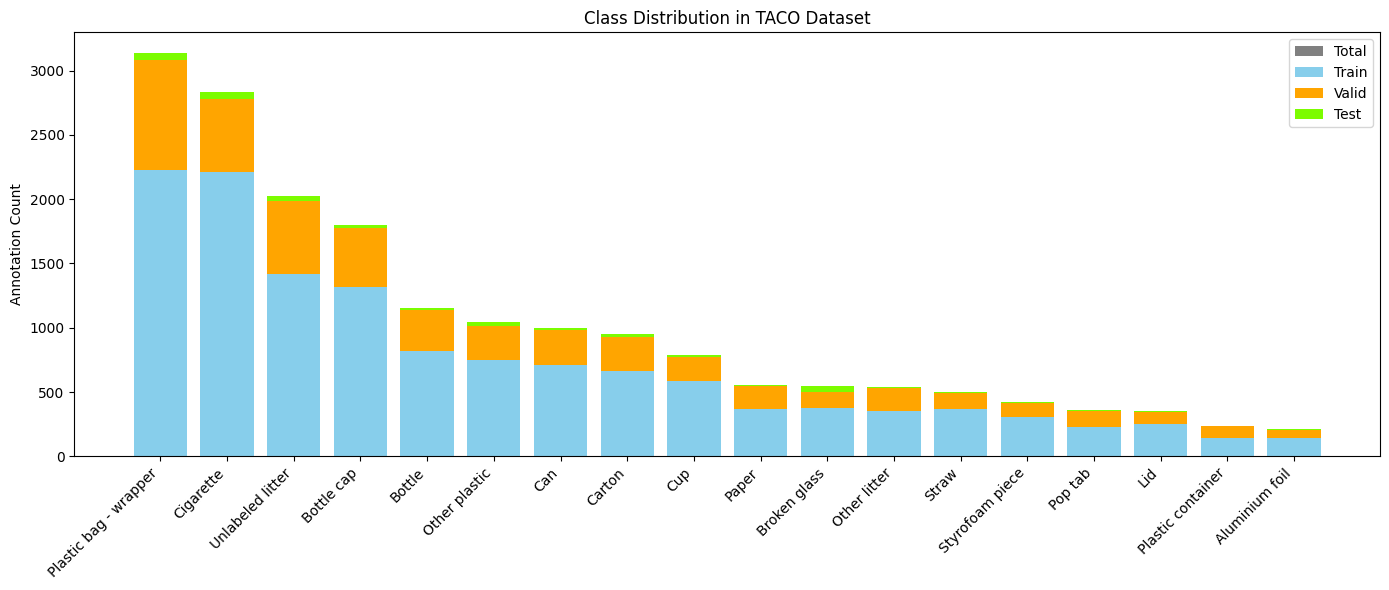

In [1]:
import os
import yaml
from collections import Counter
import matplotlib.pyplot as plt

def count_labels_in_dir(label_dir):
    counts = Counter()
    for file in os.listdir(label_dir):
        if file.endswith(".txt"):
            with open(os.path.join(label_dir, file), 'r') as f:
                for line in f:
                    if line.strip():
                        class_id = int(line.strip().split()[0])
                        counts[class_id] += 1
    return counts

def analyze_taco_dataset_structure(dataset_root):
    if not os.path.isabs(dataset_root):
        dataset_root = os.path.abspath(os.path.join(os.getcwd(), dataset_root))
    
    relative_path = os.path.relpath(dataset_root)
    print(f" Dataset: {relative_path}")

    # Load class names
    with open(os.path.join(dataset_root, "data.yaml"), 'r') as f:
        data = yaml.safe_load(f)
    class_names = data['names']
    num_classes = data['nc']

    # Define paths
    train_labels = os.path.join(dataset_root, "train/labels")
    valid_labels = os.path.join(dataset_root, "valid/labels")
    test_labels = os.path.join(dataset_root, "test/labels")

    train_counts = count_labels_in_dir(train_labels) if os.path.exists(train_labels) else Counter()
    val_counts = count_labels_in_dir(valid_labels) if os.path.exists(valid_labels) else Counter()
    test_counts = count_labels_in_dir(test_labels) if os.path.exists(test_labels) else Counter()

    total_counts = {
        i: train_counts.get(i, 0) + val_counts.get(i, 0) + test_counts.get(i, 0)
        for i in range(num_classes)
    }

    # Sorting by total count
    sorted_class_ids = sorted(total_counts.keys(), key=lambda i: total_counts[i], reverse=True)

    print(f"{'Class':<25} {'Train':<10} {'Val':<10} {'Test':<10} {'Total':<10}")
    print("-" * 65)
    for i in sorted_class_ids:
        name = class_names[i] if i < len(class_names) else f"Class {i}"
        train = train_counts.get(i, 0)
        val = val_counts.get(i, 0)
        test = test_counts.get(i, 0)
        total = total_counts[i]
        print(f"{name:<25} {train:<10} {val:<10} {test:<10} {total:<10}")

    # Plot
    labels = [class_names[i] for i in sorted_class_ids]
    train_vals = [train_counts.get(i, 0) for i in sorted_class_ids]
    val_vals = [val_counts.get(i, 0) for i in sorted_class_ids]
    test_vals = [test_counts.get(i, 0) for i in sorted_class_ids]
    total_vals = [train + val + test for train, val, test in zip(train_vals, val_vals, test_vals)]

    plt.figure(figsize=(14, 6))
    plt.bar(labels, total_vals, label='Total', color='gray')
    plt.bar(labels, train_vals, label='Train', color='skyblue')
    plt.bar(labels, val_vals, label='Valid', color='orange', bottom=train_vals)
    plt.bar(labels, test_vals, label='Test', color='lawngreen', bottom=[t + v for t, v in zip(train_vals, val_vals)])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Annotation Count')
    plt.title('Class Distribution in TACO Dataset')
    plt.legend()
    plt.tight_layout()
    plt.show()

analyze_taco_dataset_structure(r'dataset')

## Modelling

In [ ]:
from ultralytics import YOLO
import torch

# Verify CUDA is available
print(f"CUDA is available: {torch.cuda.is_available()}")

# Initialize YOLOv8 model
model = YOLO('yolov8m.pt')

results = model.train(
    data='dataset/data.yaml',
    epochs=150,                      
    imgsz=1024,
    batch=6,                                
    mosaic=0.5,
    scale=0.7,
    hsv_v=0.3,
    patience=25,
    auto_augment='randaugment',
    workers=2,
    device=0,              
    name='yolov8m',
    project='working'
)

In [ ]:
model = YOLO('working/yolov8m/weights/best.pt')
metrics = model.val()
print(metrics)

## Model Evaluation

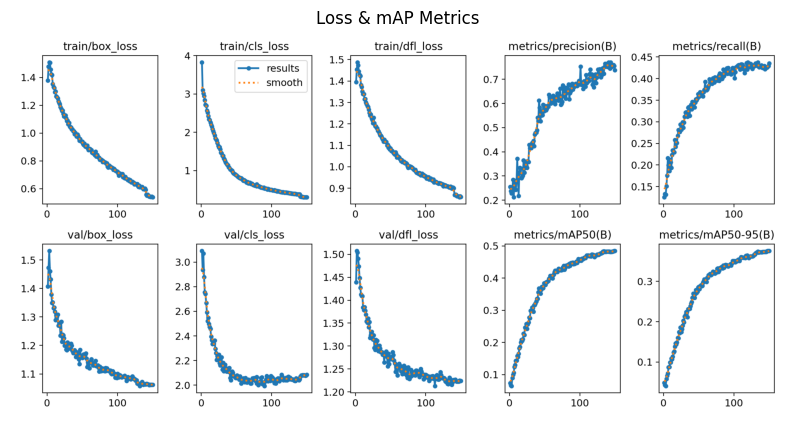

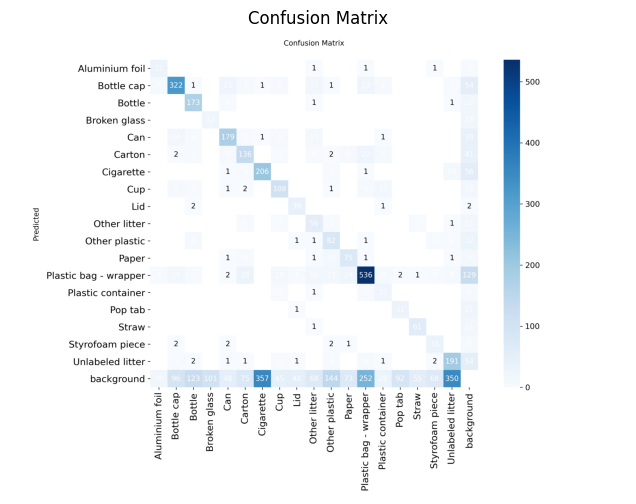

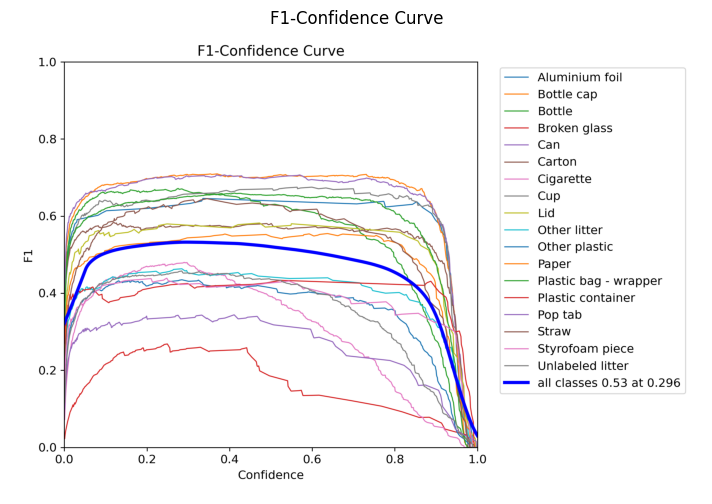

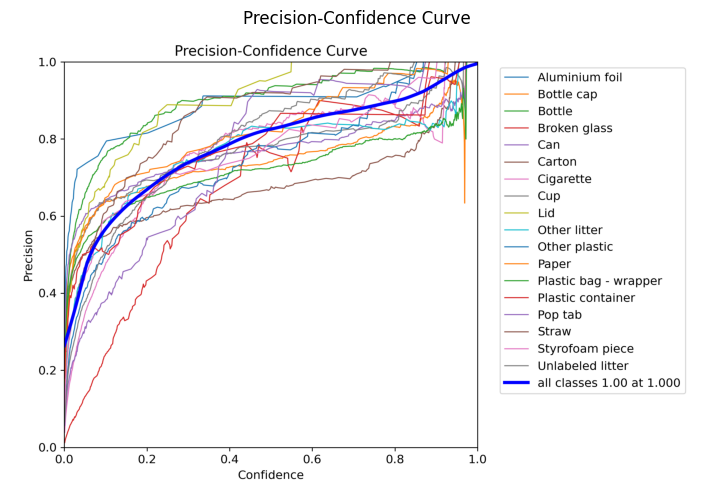

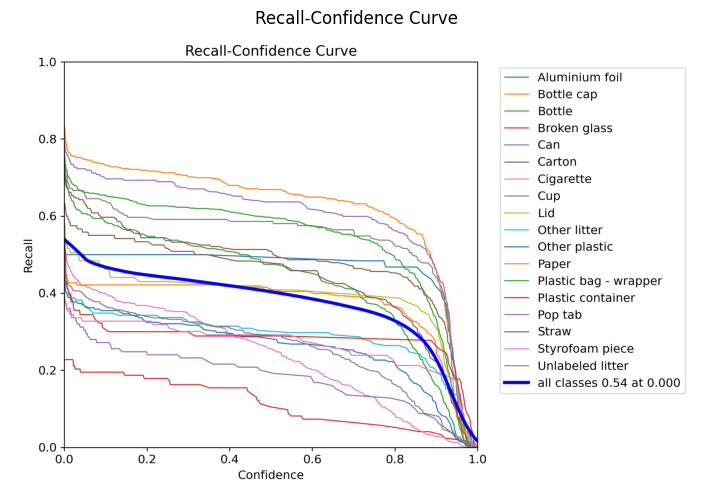

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

output = 'working/yolov8m'
def show_image(title, path):
    if os.path.exists(path):
        img = Image.open(path)
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
        plt.show()
    else:
        print(f"File not found: {path}")

# Show all results
show_image("Loss & mAP Metrics", os.path.join(output, "results.png"))
show_image("Confusion Matrix", os.path.join(output, "confusion_matrix.png"))
show_image("F1-Confidence Curve", os.path.join(output, "F1_curve.png"))
show_image("Precision-Confidence Curve", os.path.join(output, "P_curve.png"))
show_image("Recall-Confidence Curve", os.path.join(output, "R_curve.png"))


From all the model evaluation metric graphs after training above, the key results that can be taken are:
- Performance Overview
    
    With mAP50 reaching around 0,48 shows that average accuracy of bounding box detection with IoU threshold ≥ 0.5 is close to 49%. For complex datasets such as garbage (which are similar in shape/color), this is quite good. And mAP50-95 reaching around 0,35 reflects the model's ability to detect objects more strict (IoU 0.5–0.95). 

-  Confussion Matrix Analysis

    The insight that can be obtained from the confusion matrix is ​​that several classes such as Plastic wrapper and Cigarette have a high number of true positive predictions. Classes with a small number of instances (such as Styrofoam) seem to have many false negatives but this is quite common in imbalanced datasets. There are confusions between several visually similar classes, such as between Plastic wrapper, Plastic bag, and Other plastic.

- Precision Curve Analysis

    From precision curve we can see the precisions vary greatly between classes. Majority classes (e.g. Plastic wrapper) have more stable and high precision. Minor classes such as Styrofoam or Aluminum foil show fluctuating precision, it's likely due to the small number of positive predictions.

- Recall Curve Analysis

    The majority class also has high recall. But, many minor classes have low recall, meaning many objects are not detected at all.

- F1 Curve Analysis

    F1 follows the pattern of precision and recall — indicating that the precision-recall trade-off is highly dependent on the class distribution. Some classes have very low F1, even <0.3, indicating the model is barely able to recognize them well.

- Loss Function Analysis

    All loss functions (box, classification, DFL) decrease smoothly without overfitting. Training and validation losses follow similar trajectories, indicating good generalization. Metrics plateau around epoch 80-100, suggests the model has reached its learning capacity

